# Finding SSMI CDR Antarctic Regional all polynya areas - winter

* **Description**: Plots SSMI threshold polynya identification maps
    * CDR sea ice data per Laura's 4/19/22 email
* **Input data**: Processed polynya masks from L.Landrum, CCAMLR masks
* **Output data**: Netcdf file with typical polynya masks, png with plots
* **Creator**: Alice DuVivier
* **Date**: May 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import nc_time_axis

import utils

In [2]:
# choose thresholds
thresh_1 = '85%'

In [3]:
# set data info - daily data!

data_dir = '/glade/p/cesm/pcwg/landrum/SSMI/polynyas/daily/'

fin_1 = 'SSMI.CDR.'+thresh_1+'thresh.polynya2_d_sh'

In [4]:
%%time
#reading in files
ds_1 = []

print("loading CDR polynya data")   
my_files=sorted(glob.glob(data_dir+fin_1+'.*.nc'))
ds_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal',decode_times=True)

loading CDR polynya data
CPU times: user 89.2 ms, sys: 81.3 ms, total: 171 ms
Wall time: 10.5 s


In [5]:
ds_1

<xarray.Dataset>
Dimensions:          (polyID: 111, time: 15330, lat: 76, lon: 320)
Coordinates:
  * polyID           (polyID) int64 1 2 3 4 5 6 7 ... 106 107 108 109 110 111
  * time             (time) float64 1.381e+05 1.381e+05 ... 1.534e+05 1.534e+05
Dimensions without coordinates: lat, lon
Data variables:
    tlat1d           (polyID, time, lat) float32 dask.array<chunksize=(111, 5840, 76), meta=np.ndarray>
    tlon1d           (polyID, time, lon) float32 dask.array<chunksize=(111, 5840, 320), meta=np.ndarray>
    polynyas         (polyID, time, lat, lon) float64 dask.array<chunksize=(111, 5840, 76, 320), meta=np.ndarray>
    polynya_ID       (polyID, time, lat, lon) float64 dask.array<chunksize=(111, 5840, 76, 320), meta=np.ndarray>
    polynya_type     (time, polyID) float64 dask.array<chunksize=(5840, 111), meta=np.ndarray>
    polynya_area     (time, polyID) float32 dask.array<chunksize=(5840, 111), meta=np.ndarray>
    polynya_avg_lat  (time, polyID) float32 dask.array<chunksize=(5840, 111), meta=np.ndarray>
    polynya_avg_lon  (time, polyID) float32 dask.array<chunksize=(5840, 111), meta=np.ndarray>
Attributes:
    title:          SSMI daily CDR SIC fields used to calculate polynya locat...
    program:        /glade/u/home/landrum/CESM_CCSM4/AntIce/SeaBird_Predators...
    creation_date:  Wed Apr 20 19:38:32 MDT 2022

In [6]:
# keep just the variable of interest and only first polyID 
#(ncdh on the files shows that it should be only time x lat x lon in shape. Something with python loading?)

polynya_1 = ds_1['polynyas'].isel(polyID=0)

In [7]:
polynya_1

<xarray.DataArray 'polynyas' (time: 15330, lat: 76, lon: 320)>
dask.array<getitem, shape=(15330, 76, 320), dtype=float64, chunksize=(5840, 76, 320), chunktype=numpy.ndarray>
Coordinates:
    polyID   int64 1
  * time     (time) float64 1.381e+05 1.381e+05 ... 1.534e+05 1.534e+05
Dimensions without coordinates: lat, lon
Attributes:
    long_name:  Polynya grid cells with < 85% aice and bounded by aice > 85% ...

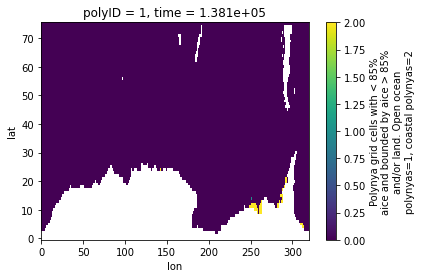

In [8]:
polynya_1.isel(time=0).plot()

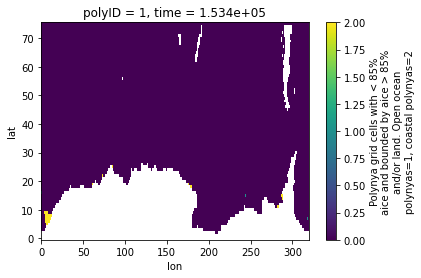

In [9]:
polynya_1.isel(time=15329).plot()

### Set all polynyas to be in mask since there are so few open water polynyas

In [10]:
# In the file, 0=not polynya, 1=open water polynya, 2=coastal polynya
# We want to look at all polynyas for now, so set coastal to one also
polynya_1 = polynya_1.where(polynya_1 != 2,1)

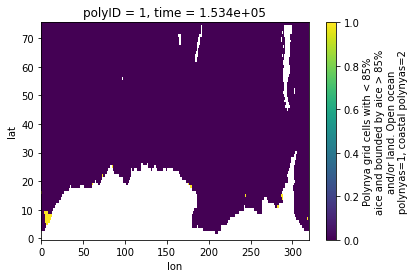

In [11]:
# check
polynya_1.isel(time=15329).plot()

### Fix time array to be useable

In [12]:
# starts 1979-01-01 and ends 2020-12-31
my_files

['/glade/p/cesm/pcwg/landrum/SSMI/polynyas/daily/SSMI.CDR.85%thresh.polynya2_d_sh.19790101-19941231.nc',
 '/glade/p/cesm/pcwg/landrum/SSMI/polynyas/daily/SSMI.CDR.85%thresh.polynya2_d_sh.19950101-20091231.nc',
 '/glade/p/cesm/pcwg/landrum/SSMI/polynyas/daily/SSMI.CDR.85%thresh.polynya2_d_sh.20100101-20201231.nc']

In [13]:
# looks like there are 15330 times, which is 42 yrs * 365 days. So no leap years
# real leap years are: 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2016, 2020
polynya_1.time

<xarray.DataArray 'time' (time: 15330)>
array([138061., 138062., 138063., ..., 153399., 153400., 153401.])
Coordinates:
    polyID   int64 1
  * time     (time) float64 1.381e+05 1.381e+05 ... 1.534e+05 1.534e+05
Attributes:
    cell_methods:  time: mean

In [14]:
# make array of the dates
dates = pd.date_range(start="1979-01-01", end="2020-12-31", freq="D")

In [15]:
# this doesn't match up, so it must include leapdays
len(dates)

15341

In [16]:
# reassign array and remove the leap days
dates = dates[~((dates.month == 2) & (dates.day == 29))]

In [17]:
len(dates)

15330

In [18]:
# reassign the time array
polynya_1['time'] = dates

In [19]:
polynya_1.time.dt.month

<xarray.DataArray 'month' (time: 15330)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
    polyID   int64 1
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31

## Get just winter months - JAS

In [20]:
polynya_winter_1 = polynya_1.where((polynya_1.time.dt.month >= 7) & (polynya_1.time.dt.month <= 9), drop=True)

In [21]:
polynya_winter_1.time

<xarray.DataArray 'time' (time: 3864)>
array(['1979-07-01T00:00:00.000000000', '1979-07-02T00:00:00.000000000',
       '1979-07-03T00:00:00.000000000', ..., '2020-09-28T00:00:00.000000000',
       '2020-09-29T00:00:00.000000000', '2020-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    polyID   int64 1
  * time     (time) datetime64[ns] 1979-07-01 1979-07-02 ... 2020-09-30

## Calculate typical polynya regions over all times

In [22]:
# calculate percent over all times
total_time = len(polynya_1.time)
winter_time = len(polynya_winter_1.time)

pct_all = polynya_1.sum(dim='time')/total_time
pct_winter = polynya_winter_1.sum(dim='time')/winter_time

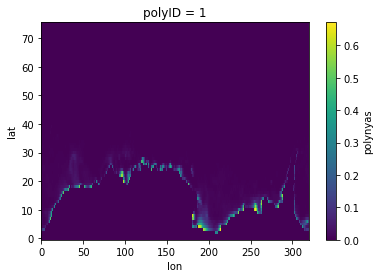

In [23]:
pct_all.plot()

In [24]:
# make an array of "typical" polynyas
# define this as when polynyas happen >10% of the total time

# make array to fill
polynya_typical_all = pct_all.where(pct_all == 1, other = 1)
polynya_typical_winter = pct_winter.where(pct_winter == 1, other = 1)

# keep values where polynyas > 10% (0.1) of the time (reduce the frequency for other masks)
polynya_typical_all = polynya_typical_all.where(pct_all >= 0.1)
polynya_typical_winter = polynya_typical_winter.where(pct_winter >= 0.1)


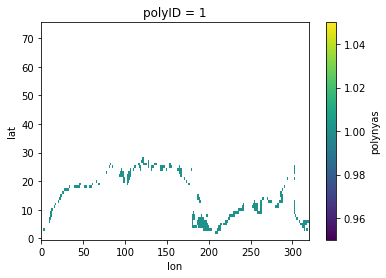

In [25]:
polynya_typical_all.plot()

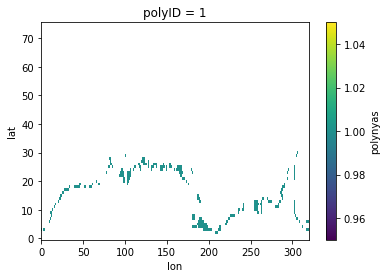

In [26]:
polynya_typical_winter.plot()

In [27]:
polynya_typical_all

<xarray.DataArray 'polynyas' (lat: 76, lon: 320)>
dask.array<where, shape=(76, 320), dtype=float64, chunksize=(76, 320), chunktype=numpy.ndarray>
Coordinates:
    polyID   int64 1
Dimensions without coordinates: lat, lon

## Get grid data

In [28]:
# get pop grid grid cell areas
grid = pop_tools.get_grid('POP_gx1v7')
grid

# convert tarea to m^2
tarea = grid['TAREA']/(1e4)
tarea = tarea.rename({'nlat':'lat','nlon': 'lon'})

# get lat and lon
TLAT = grid['TLAT']
TLAT = TLAT.rename({'nlat':'lat','nlon': 'lon'})
TLONG = grid['TLONG']
TLONG = TLONG.rename({'nlat':'lat','nlon': 'lon'})

In [29]:
TLAT

<xarray.DataArray 'TLAT' (lat: 384, lon: 320)>
array([[-79.22052261, -79.22052261, -79.22052261, ..., -79.22052261,
        -79.22052261, -79.22052261],
       [-78.68630626, -78.68630626, -78.68630626, ..., -78.68630626,
        -78.68630626, -78.68630626],
       [-78.15208992, -78.15208992, -78.15208992, ..., -78.15208992,
        -78.15208992, -78.15208992],
       ...,
       [ 71.29031715,  71.29408252,  71.30160692, ...,  71.30160692,
         71.29408252,  71.29031716],
       [ 71.73524335,  71.73881845,  71.74596231, ...,  71.74596231,
         71.73881845,  71.73524335],
       [ 72.18597561,  72.18933231,  72.19603941, ...,  72.19603941,
         72.18933231,  72.18597562]])
Dimensions without coordinates: lat, lon
Attributes:
    units:      degrees_north
    long_name:  T-grid latitude

In [30]:
# Drop latitudes greater than what was in polynya files so that array sizes match.
TLAT_sub = TLAT.isel(lat=slice(0,76))
TLONG_sub = TLONG.isel(lat=slice(0,76))

In [31]:
TLAT_sub

<xarray.DataArray 'TLAT' (lat: 76, lon: 320)>
array([[-79.22052261, -79.22052261, -79.22052261, ..., -79.22052261,
        -79.22052261, -79.22052261],
       [-78.68630626, -78.68630626, -78.68630626, ..., -78.68630626,
        -78.68630626, -78.68630626],
       [-78.15208992, -78.15208992, -78.15208992, ..., -78.15208992,
        -78.15208992, -78.15208992],
       ...,
       [-40.22185545, -40.22185545, -40.22185545, ..., -40.22185545,
        -40.22185545, -40.22185545],
       [-39.68761093, -39.68761093, -39.68761093, ..., -39.68761093,
        -39.68761093, -39.68761093],
       [-39.15336593, -39.15336593, -39.15336593, ..., -39.15336593,
        -39.15336593, -39.15336593]])
Dimensions without coordinates: lat, lon
Attributes:
    units:      degrees_north
    long_name:  T-grid latitude

## Save the typical polynya mask as a netcdf

In [32]:
print(polynya_typical_all.shape)
print(polynya_typical_winter.shape)

(76, 320)
(76, 320)


In [33]:
polynya_typical_all

<xarray.DataArray 'polynyas' (lat: 76, lon: 320)>
dask.array<where, shape=(76, 320), dtype=float64, chunksize=(76, 320), chunktype=numpy.ndarray>
Coordinates:
    polyID   int64 1
Dimensions without coordinates: lat, lon

In [34]:
polynya_typical_winter

<xarray.DataArray 'polynyas' (lat: 76, lon: 320)>
dask.array<where, shape=(76, 320), dtype=float64, chunksize=(76, 320), chunktype=numpy.ndarray>
Coordinates:
    polyID   int64 1
Dimensions without coordinates: lat, lon

In [35]:
TLONG_sub

<xarray.DataArray 'TLONG' (lat: 76, lon: 320)>
array([[320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       [320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       [320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       ...,
       [320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       [320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889],
       [320.56250892, 321.68750895, 322.81250898, ..., 317.18750883,
        318.31250886, 319.43750889]])
Dimensions without coordinates: lat, lon
Attributes:
    units:      degrees_east
    long_name:  T-grid longitude

In [36]:
ds_to_save = xr.Dataset({'polynya_typical_all':(['lat','lon'],polynya_typical_all.data),
                         'polynya_typical_winter':(['lat','lon'],polynya_typical_winter.data),
                         'TLAT_sub':(['lat','lon'],TLAT_sub.data),
                         'TLONG_sub':(['lat','lon'],TLONG_sub.data)},
                        attrs={'Author':'Alice DuVivier'})
                                

In [37]:
ds_to_save

<xarray.Dataset>
Dimensions:                 (lat: 76, lon: 320)
Dimensions without coordinates: lat, lon
Data variables:
    polynya_typical_all     (lat, lon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    polynya_typical_winter  (lat, lon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    TLAT_sub                (lat, lon) float64 -79.22 -79.22 ... -39.15 -39.15
    TLONG_sub               (lat, lon) float64 320.6 321.7 322.8 ... 318.3 319.4
Attributes:
    Author:   Alice DuVivier

In [38]:
# set output name and save file
fout = 'ssmi_cdr_typical_polynya_mask_'+thresh_1+'thresh'

ds_to_save.to_netcdf(fout+'.nc')  # how to save file